<a href="https://colab.research.google.com/github/kisung2577/CMPE-258/blob/main/Write_advanced_deep_learning_pipeline_for_training_which_uses_a_lot_of_custom_components.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Import Required Libraries

In [ ]:
from packaging import version
import tensorflow as tf
import numpy as np
import keras
import sys
from tensorflow.keras import optimizers

###Custom Loss Function

In [ ]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss  = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

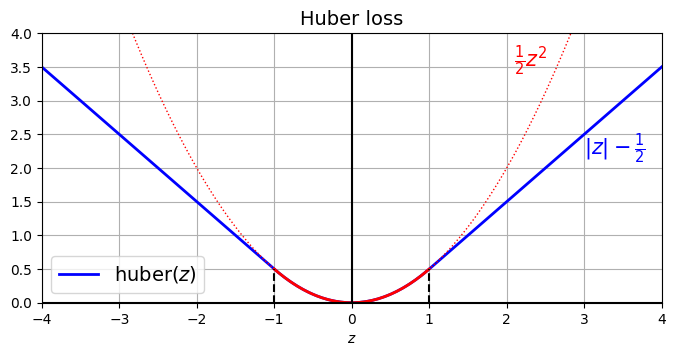

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
z_center = np.linspace(-1, 1, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z ** 2 / 2, "r:", linewidth=1)
plt.plot(z_center, z_center ** 2 / 2, "r", linewidth=2)
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "k--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "k--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.text(2.1, 3.5, r"$\frac{1}{2}z^2$", color="r", fontsize=15)
plt.text(3.0, 2.2, r"$|z| - \frac{1}{2}$", color="b", fontsize=15)
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

Testing the custom loss function - using the california housing dataset

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

input_shape = X_train.shape[1:]

tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

In [ ]:
model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=10,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/10
363/363 [==============================] - 10s 15ms/step - loss: 0.5753 - mae: 0.9431 - val_loss: 0.3886 - val_mae: 0.7119
Epoch 2/10
363/363 [==============================] - 5s 13ms/step - loss: 0.2585 - mae: 0.5677 - val_loss: 0.2551 - val_mae: 0.5445
Epoch 3/10
363/363 [==============================] - 3s 10ms/step - loss: 0.2041 - mae: 0.4904 - val_loss: 0.1936 - val_mae: 0.4647
Epoch 4/10
363/363 [==============================] - 3s 7ms/step - loss: 0.1857 - mae: 0.4631 - val_loss: 0.1689 - val_mae: 0.4392
Epoch 5/10
363/363 [==============================] - 2s 7ms/step - loss: 0.1781 - mae: 0.4521 - val_loss: 0.1661 - val_mae: 0.4354
Epoch 6/10
363/363 [==============================] - 2s 6ms/step - loss: 0.1740 - mae: 0.4457 - val_loss: 0.1609 - val_mae: 0.4234
Epoch 7/10
363/363 [==============================] - 2s 6ms/step - loss: 0.1711 - mae: 0.4417 - val_loss: 0.1601 - val_mae: 0.4252
Epoch 8/10
363/363 [==============================] - 3s 8ms/step - loss

###Saving/loading models with custom objects

In [ ]:
model.save("my_model_with_a_custom_loss")

In [ ]:
model = tf.keras.models.load_model("my_model_with_a_custom_loss",
                                   custom_objects={"huber_fn": huber_fn})

In [ ]:
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
363/363 [==============================] - 2s 3ms/step - loss: 0.1631 - mae: 0.4276 - val_loss: 0.1558 - val_mae: 0.4152
Epoch 2/5
363/363 [==============================] - 1s 3ms/step - loss: 0.1612 - mae: 0.4250 - val_loss: 0.1559 - val_mae: 0.4200
Epoch 3/5
363/363 [==============================] - 1s 3ms/step - loss: 0.1594 - mae: 0.4217 - val_loss: 0.1509 - val_mae: 0.4065
Epoch 4/5
363/363 [==============================] - 1s 3ms/step - loss: 0.1581 - mae: 0.4197 - val_loss: 0.1579 - val_mae: 0.4155
Epoch 5/5
363/363 [==============================] - 2s 4ms/step - loss: 0.1568 - mae: 0.4173 - val_loss: 0.1831 - val_mae: 0.4445


In [ ]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold ** 2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

In [ ]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=["mae"])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 0.1753 - mae: 0.4194 - val_loss: 0.1850 - val_mae: 0.4140
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.1741 - mae: 0.4182 - val_loss: 0.1757 - val_mae: 0.4179


In [ ]:
model.save("my_model_with_a_custom_loss_threshold_2")

In [ ]:
model = tf.keras.models.load_model("my_model_with_a_custom_loss_threshold_2",
                                   custom_objects={"huber_fn": create_huber(2.0)})

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 4ms/step - loss: 0.1726 - mae: 0.4163 - val_loss: 0.1669 - val_mae: 0.4038
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.1713 - mae: 0.4151 - val_loss: 0.1805 - val_mae: 0.4191


In [ ]:
class HuberLoss(tf.keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)

    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [ ]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

In [ ]:
model.compile(loss=HuberLoss(2.), optimizer="nadam", metrics=["mae"])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 4ms/step - loss: 0.7789 - mae: 0.9424 - val_loss: 0.3524 - val_mae: 0.6229
Epoch 2/2
363/363 [==============================] - 2s 5ms/step - loss: 0.3194 - mae: 0.5857 - val_loss: 0.2639 - val_mae: 0.5303


In [ ]:
model.save("my_model_with_a_custom_loss_class") 

In [ ]:
model = tf.keras.models.load_model("my_model_with_a_custom_loss_class",
                                   custom_objects={"HuberLoss": HuberLoss})

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 0.2477 - mae: 0.5107 - val_loss: 0.2289 - val_mae: 0.4786
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2157 - mae: 0.4748 - val_loss: 0.2275 - val_mae: 0.4708


In [ ]:
model.loss.threshold

2.0

###Custom Activation Function

In [ ]:
def my_softplus(z):
    return tf.math.log(1.0 + tf.exp(z))

###Custom Initializer

In [ ]:
def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

###Custom Regularizer

In [ ]:
def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

###Custom Weight Function

In [ ]:
def my_positive_weights(weights):  # return value is just tf.nn.relu(weights)
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [ ]:
layer = tf.keras.layers.Dense(1, activation=my_softplus,
                              kernel_initializer=my_glorot_initializer,
                              kernel_regularizer=my_l1_regularizer,
                              kernel_constraint=my_positive_weights)

In [ ]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1, activation=my_softplus,
                          kernel_initializer=my_glorot_initializer,
                          kernel_regularizer=my_l1_regularizer,
                          kernel_constraint=my_positive_weights)
])
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.save("my_model_with_many_custom_parts")
model = tf.keras.models.load_model(
    "my_model_with_many_custom_parts",
    custom_objects={
       "my_l1_regularizer": my_l1_regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    }
)
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 3s 3ms/step - loss: 1.8677 - mae: 0.8947 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.9942 - mae: 0.6455 - val_loss: inf - val_mae: inf


Epoch 1/2
363/363 [==============================] - 3s 5ms/step - loss: 0.6443 - mae: 0.5512 - val_loss: 2.1254 - val_mae: 0.5411
Epoch 2/2
363/363 [==============================] - 2s 5ms/step - loss: 0.5398 - mae: 0.5126 - val_loss: 1.4639 - val_mae: 0.5134


###Writing class for Custom Regularizer

In [ ]:
class MyL1Regularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor

    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))

    def get_config(self):
        return {"factor": self.factor}

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1, activation=my_softplus,
                          kernel_regularizer=MyL1Regularizer(0.01),
                          kernel_constraint=my_positive_weights,
                          kernel_initializer=my_glorot_initializer),
])
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.save("my_model_with_many_custom_parts")
model = tf.keras.models.load_model(
    "my_model_with_many_custom_parts",
    custom_objects={
       "MyL1Regularizer": MyL1Regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    }
)
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 2.5993 - mae: 0.8726 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 1.4166 - mae: 0.6639 - val_loss: inf - val_mae: inf


Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 0.7955 - mae: 0.5521 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.6185 - mae: 0.5051 - val_loss: inf - val_mae: inf


###Custom Metrics

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])
model.compile(loss="mse", optimizer="nadam", metrics=[create_huber(2.0)])
# extra code – train the model with our custom metric
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 1.8759 - huber_fn: 0.8121
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.6954 - huber_fn: 0.3338


In [ ]:
class HuberMetric(tf.keras.metrics.Mean):
    def __init__(self, threshold=1.0, name='HuberMetric', dtype=None):
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        super().__init__(name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        super(HuberMetric, self).update_state(metric, sample_weight)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}        

tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])
model.compile(loss=tf.keras.losses.Huber(2.0), optimizer="nadam",
              weighted_metrics=[HuberMetric(2.0)])
np.random.seed(42)
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled, y_train, epochs=2,
                    sample_weight=sample_weight)

(history.history["loss"][0],
 history.history["HuberMetric"][0] * sample_weight.mean())

model.save("my_model_with_a_custom_metric_v2")

model = tf.keras.models.load_model("my_model_with_a_custom_metric_v2",
                                   custom_objects={"HuberMetric": HuberMetric})
model.fit(X_train_scaled, y_train, epochs=2)
model.metrics[-1].threshold

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 0.4011 - HuberMetric: 0.8082
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.1596 - HuberMetric: 0.3216


Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 0.2564 - HuberMetric: 0.2564
Epoch 2/2
363/363 [==============================] - 2s 4ms/step - loss: 0.2240 - HuberMetric: 0.2240


2.0

###Custom Model

In [ ]:
class CustomModel(tf.keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu",
                                             kernel_initializer="he_normal")
                       for _ in range(n_layers)]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z
class CustomRegressor(tf.keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = tf.keras.layers.Dense(30, activation="relu",
                                             kernel_initializer="he_normal")
        self.block1 = CustomModel(2, 30)
        self.block2 = CustomModel(2, 30)
        self.out = tf.keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

# extra code – shows that the model can be used normally
tf.random.set_seed(42)
model = CustomRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=2)
score = model.evaluate(X_test_scaled, y_test)
model.save("my_custom_model")


model = tf.keras.models.load_model("my_custom_model")
history = model.fit(X_train_scaled, y_train, epochs=2)
model.predict(X_test_scaled[:3])


tf.random.set_seed(42)
block1 = CustomModel(2, 30)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu",
                          kernel_initializer="he_normal"),
    block1, block1, block1, block1,
    CustomModel(2, 30),
    tf.keras.layers.Dense(1)
])

Epoch 1/2
363/363 [==============================] - 5s 4ms/step - loss: 11.9930
Epoch 2/2
162/162 [==============================] - 1s 3ms/step - loss: 1.0245


Epoch 1/2
363/363 [==============================] - 4s 4ms/step - loss: 0.9374
Epoch 2/2
1/1 [==============================] - 0s 132ms/step


###Custom Optimizer

In [ ]:
class MyOptimizer(optimizers.Optimizer):
    def __init__(self, learning_rate=0.01, momentum=0.0, name="MyOptimizer", **kwargs):
        super(MyOptimizer, self).__init__(name, **kwargs)
        self._set_hyper("learning_rate", kwargs.get("lr", learning_rate))
        self._set_hyper("momentum", momentum)

    def _create_slots(self, var_list):
        for var in var_list:
            self.add_slot(var, "momentum")

    @tf.function
    def _resource_apply_dense(self, grad, var):
        var_dtype = var.dtype.base_dtype
        lr_t = self._decayed_lr(var_dtype)
        momentum_var = self.get_slot(var, "momentum")
        momentum = self._get_hyper("momentum", var_dtype)
        momentum_var.assign(momentum_var * momentum - lr_t * grad)
        var.assign_add(momentum_var)

    def _resource_apply_sparse(self, grad, var):
        raise NotImplementedError("Sparse gradient updates are not supported.")

    def get_config(self):
        config = super(MyOptimizer, self).get_config()
        config.update({
            "learning_rate": self._serialize_hyperparameter("learning_rate"),
            "momentum": self._serialize_hyperparameter("momentum"),
        })
        return config


### Custom loss function

In [ ]:
def my_mse(y_true, y_pred):
    print("Tracing loss my_mse()")
    return tf.reduce_mean(tf.square(y_pred - y_true))

###Custom Callback

In [ ]:
class PrintLossCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print("Loss:", logs["loss"])

In [ ]:
model.compile(loss=my_mse, optimizer="sgd")
model.fit(X_train, y_train, epochs=5, callbacks=[PrintLossCallback()])

Epoch 1/5
Tracing loss my_mse()
Tracing loss my_mse()
363/363 [==============================] - 2s 4ms/step - loss: nan
Epoch 2/5
363/363 [==============================] - 1s 3ms/step - loss: nan
Epoch 3/5
363/363 [==============================] - 1s 2ms/step - loss: nan
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: nan
Epoch 5/5
363/363 [==============================] - 1s 3ms/step - loss: nan


### Custom layer

In [ ]:
class MyDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.units),
                                      initializer='uniform',
                                      trainable=True)
        self.biases = self.add_weight(name='bias', 
                                      shape=(self.units,),
                                      initializer='zeros',
                                      trainable=True)
        super().build(input_shape)

    def call(self, X):
        print("Tracing MyDense.call()")
        return self.activation(X @ self.kernel + self.biases)

###Trying another Custom Metric

In [ ]:
# Custom metric function
def my_mae(y_true, y_pred):
    print("Tracing metric my_mae()")
    return tf.reduce_mean(tf.abs(y_pred - y_true))

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

In [ ]:
model.compile(loss="mse", optimizer="nadam", metrics=[create_huber(2.0)])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 3s 4ms/step - loss: 1.4930 - huber_fn: 0.6777
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.6795 - huber_fn: 0.3279


Streaming Metrics

In [ ]:
precision = tf.keras.metrics.Precision()
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.8>

In [ ]:
precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [ ]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [ ]:
precision.variables

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>]

In [ ]:
precision.reset_states()

In [ ]:
class HuberMetric(tf.keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs)  # handles base args (e.g., dtype)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        sample_metrics = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(sample_metrics))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))

    def result(self):
        return self.total / self.count

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [ ]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

In [ ]:
model.compile(loss=create_huber(2.0), optimizer="nadam",
              metrics=[HuberMetric(2.0)])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 0.5575 - huber_metric: 0.5575
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2950 - huber_metric: 0.2950


In [ ]:
model.save("my_model_with_a_custom_metric")

In [ ]:
model = tf.keras.models.load_model(
    "my_model_with_a_custom_metric",
    custom_objects={
        "huber_fn": create_huber(2.0),
        "HuberMetric": HuberMetric
    }
)

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 0.2365 - huber_metric: 0.2365
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2146 - huber_metric: 0.2146


In [ ]:
model.metrics[-1].threshold

2.0

### Class for custom metrics

In [ ]:
class HuberMetric(tf.keras.metrics.Mean):
    def __init__(self, threshold=1.0, name='HuberMetric', dtype=None):
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        super().__init__(name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        super(HuberMetric, self).update_state(metric, sample_weight)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}  

In [ ]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

In [ ]:
model.compile(loss=tf.keras.losses.Huber(2.0), optimizer="nadam",
              weighted_metrics=[HuberMetric(2.0)])

In [ ]:
np.random.seed(42)
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled, y_train, epochs=2,
                    sample_weight=sample_weight)

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 0.5475 - HuberMetric: 1.1034
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.1630 - HuberMetric: 0.3286


In [ ]:
(history.history["loss"][0],
 history.history["HuberMetric"][0] * sample_weight.mean())

(0.5475473403930664, 0.547547438784181)

In [ ]:
model.save("my_model_with_a_custom_metric_v2")

In [ ]:
model = tf.keras.models.load_model("my_model_with_a_custom_metric_v2",
                                   custom_objects={"HuberMetric": HuberMetric})

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 0.2651 - HuberMetric: 0.2651
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2255 - HuberMetric: 0.2255


In [ ]:
model.metrics[-1].threshold

2.0

###Custom Layers

In [ ]:
exponential_layer = tf.keras.layers.Lambda(lambda x: tf.exp(x))

In [ ]:
exponential_layer([-1., 0., 1.])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.36787945, 1.        , 2.7182817 ], dtype=float32)>

In [ ]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", input_shape=input_shape),
    tf.keras.layers.Dense(1),
    exponential_layer
])
model.compile(loss="mse", optimizer="sgd")
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/5
363/363 [==============================] - 2s 4ms/step - loss: 1.0284 - val_loss: 0.4407
Epoch 2/5
363/363 [==============================] - 1s 4ms/step - loss: 0.5395 - val_loss: 0.4043
Epoch 3/5
363/363 [==============================] - 1s 3ms/step - loss: 0.4213 - val_loss: 0.3676
Epoch 4/5
363/363 [==============================] - 1s 3ms/step - loss: 0.4008 - val_loss: 0.3605
Epoch 5/5
162/162 [==============================] - 0s 2ms/step - loss: 0.3788


0.37884315848350525

###Alternative method for Custom Layers

In [ ]:
class MyDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="he_normal")
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")
        super().build(batch_input_shape)  # must be at the end

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": tf.keras.activations.serialize(self.activation)}

In [ ]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    MyDense(30, activation="relu", input_shape=input_shape),
    MyDense(1)
])
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)
model.save("my_model_with_a_custom_layer")

Epoch 1/2
363/363 [==============================] - 2s 4ms/step - loss: 1.9202 - val_loss: 14.5691
Epoch 2/2
162/162 [==============================] - 0s 3ms/step - loss: 0.5919


In [ ]:
model = tf.keras.models.load_model("my_model_with_a_custom_layer",
                                   custom_objects={"MyDense": MyDense})
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 4ms/step - loss: 0.5672 - val_loss: 3.0162
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.4649 - val_loss: 0.9741


In [ ]:
class MyMultiLayer(tf.keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        print("X1.shape: ", X1.shape ," X2.shape: ", X2.shape)  # extra code
        return X1 + X2, X1 * X2, X1 / X2

    def compute_output_shape(self, batch_input_shape):
        batch_input_shape1, batch_input_shape2 = batch_input_shape
        return [batch_input_shape1, batch_input_shape1, batch_input_shape1]

In [ ]:
inputs1 = tf.keras.layers.Input(shape=[2])
inputs2 = tf.keras.layers.Input(shape=[2])
MyMultiLayer()((inputs1, inputs2))

X1.shape:  (None, 2)  X2.shape:  (None, 2)


(<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'my_multi_layer')>,
 <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'my_multi_layer')>,
 <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'my_multi_layer')>)

In [ ]:
X1, X2 = np.array([[3., 6.], [2., 7.]]), np.array([[6., 12.], [4., 3.]]) 
MyMultiLayer()((X1, X2))

X1.shape:  (2, 2)  X2.shape:  (2, 2)


(<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[ 9., 18.],
        [ 6., 10.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[18., 72.],
        [ 8., 21.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[0.5      , 0.5      ],
        [0.5      , 2.3333333]], dtype=float32)>)

In [ ]:
class MyGaussianNoise(tf.keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

Custom Seed

In [ ]:
SEED = 42
tf.random.set_seed(SEED)
model = tf.keras.Sequential([
    MyGaussianNoise(stddev=1.0, input_shape=input_shape),
    tf.keras.layers.Dense(30, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 2.7580 - val_loss: 3.4831
Epoch 2/2
162/162 [==============================] - 0s 3ms/step - loss: 0.9994


0.9994276762008667

Custom Gradient and Custom tf function

In [ ]:
import tensorflow as tf

@tf.custom_gradient
def custom_func(x):
    """Example custom function with custom gradient"""
    y = x ** 2
    
    def grad(dy):
        dx = 2 * x * dy
        return dx
    
    return y, grad

# Test the custom function
x = tf.constant(3.0)
with tf.GradientTape() as tape:
    tape.watch(x)
    y = custom_func(x)
    
print("y:", y.numpy())
dy_dx = tape.gradient(y, x)
print("dy/dx:", dy_dx.numpy()) 


y: 9.0
dy/dx: 6.0


###Custom Models

In [ ]:
class CustomModel(tf.keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu",
                                             kernel_initializer="he_normal")
                       for _ in range(n_layers)]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z

In [ ]:
class CustomRegressor(tf.keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = tf.keras.layers.Dense(30, activation="relu",
                                             kernel_initializer="he_normal")
        self.block1 = CustomModel(2, 30)
        self.block2 = CustomModel(2, 30)
        self.out = tf.keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

In [ ]:
tf.random.set_seed(42)
model = CustomRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=2)
score = model.evaluate(X_test_scaled, y_test)
model.save("my_custom_model")

Epoch 1/2
363/363 [==============================] - 4s 3ms/step - loss: 40.4171
Epoch 2/2
162/162 [==============================] - 0s 2ms/step - loss: 1.0958


In [ ]:
model = tf.keras.models.load_model("my_custom_model")
history = model.fit(X_train_scaled, y_train, epochs=2)
model.predict(X_test_scaled[:3])

Epoch 1/2
363/363 [==============================] - 5s 4ms/step - loss: 1.5802
Epoch 2/2
1/1 [==============================] - 0s 83ms/step


array([[0.8643661],
       [1.7902993],
       [3.6603014]], dtype=float32)

###Custom Training Loops

In [ ]:
l2_reg = tf.keras.regularizers.l2(0.05)
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          kernel_regularizer=l2_reg),
    tf.keras.layers.Dense(1, kernel_regularizer=l2_reg)
])

In [ ]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

In [ ]:
def print_status_bar(step, total, loss, metrics=None):
    metrics = " - ".join([f"{m.name}: {m.result():.4f}"
                          for m in [loss] + (metrics or [])])
    end = "" if step < total else "\n"
    print(f"\r{step}/{total} - " + metrics, end=end)

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.mean_squared_error
mean_loss = tf.keras.metrics.Mean()
metrics = [tf.keras.metrics.MeanAbsoluteError()]

In [ ]:
for epoch in range(1, n_epochs + 1):
    print(f"Epoch {epoch}/{n_epochs}")
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train_scaled, y_train)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch, training=True)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # extra code – if your model has variable constraints
        for variable in model.variables:
            if variable.constraint is not None:
                variable.assign(variable.constraint(variable))

        mean_loss(loss)
        for metric in metrics:
            metric(y_batch, y_pred)

        print_status_bar(step, n_steps, mean_loss, metrics)

    for metric in [mean_loss] + metrics:
        metric.reset_states()

Epoch 1/5
362/362 - mean: 2.8339 - mean_absolute_error: 0.6041
Epoch 2/5
362/362 - mean: 1.5597 - mean_absolute_error: 0.5149
Epoch 3/5
362/362 - mean: 1.0445 - mean_absolute_error: 0.4964
Epoch 4/5
362/362 - mean: 0.8143 - mean_absolute_error: 0.4927
Epoch 5/5
362/362 - mean: 0.7091 - mean_absolute_error: 0.4992


In [ ]:
from tqdm.notebook import trange
from collections import OrderedDict
with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc=f"Epoch {epoch}/{n_epochs}") as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train_scaled, y_train)
                with tf.GradientTape() as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)

                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))

                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))

                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()

                steps.set_postfix(status)

        for metric in [mean_loss] + metrics:
            metric.reset_states()

All epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/362 [00:00<?, ?it/s]

###Custom Learning Rate Scheduler

In [ ]:
import math

In [ ]:
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(keras.backend.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        keras.backend.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

In [ ]:
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = keras.backend.get_value(model.optimizer.learning_rate)
    keras.backend.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    keras.backend.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

In [ ]:
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

###Adding Custom Seed with model

In [ ]:
SEED = 42
tf.random.set_seed(SEED)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

430/430 [==============================] - 5s 11ms/step - loss: 13224153.0000 - accuracy: 0.3655


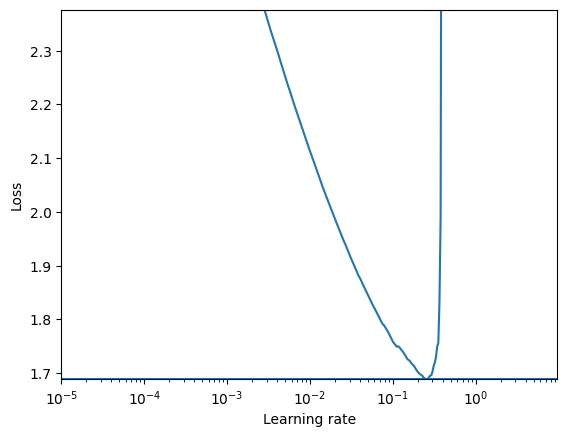

In [ ]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [ ]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        keras.backend.set_value(self.model.optimizer.learning_rate, rate)

In [ ]:
n_epochs = 10
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/10
430/430 [==============================] - 4s 10ms/step - loss: 0.6370 - accuracy: 0.7783 - val_loss: 0.4728 - val_accuracy: 0.8346
Epoch 2/10
430/430 [==============================] - 5s 11ms/step - loss: 0.4388 - accuracy: 0.8455 - val_loss: 0.4209 - val_accuracy: 0.8520
Epoch 3/10
430/430 [==============================] - 4s 9ms/step - loss: 0.3960 - accuracy: 0.8586 - val_loss: 0.3999 - val_accuracy: 0.8616
Epoch 4/10
430/430 [==============================] - 4s 9ms/step - loss: 0.3683 - accuracy: 0.8683 - val_loss: 0.3698 - val_accuracy: 0.8670
Epoch 5/10
430/430 [==============================] - 4s 10ms/step - loss: 0.3488 - accuracy: 0.8743 - val_loss: 0.3510 - val_accuracy: 0.8766
Epoch 6/10
430/430 [==============================] - 4s 10ms/step - loss: 0.3132 - accuracy: 0.8881 - val_loss: 0.3472 - val_accuracy: 0.8796
Epoch 7/10
430/430 [==============================] - 4s 10ms/step - loss: 0.2904 - accuracy: 0.8957 - val_loss: 0.3361 - val_accuracy: 0.8814
E

###Custom Gradient and Custom TF function

In [ ]:
import tensorflow as tf

@tf.custom_gradient
def custom_func(x):
    """Example custom function with custom gradient"""
    y = x ** 2
    
    def grad(dy):
        dx = 2 * x * dy
        return dx
    
    return y, grad

# Test the custom function
x = tf.constant(3.0)
with tf.GradientTape() as tape:
    tape.watch(x)
    y = custom_func(x)
    
print("y:", y.numpy())
dy_dx = tape.gradient(y, x)
print("dy/dx:", dy_dx.numpy()) 

y: 9.0
dy/dx: 6.0


###Custom Dropout

In [ ]:
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

In [ ]:

np.round(model.predict(X_test_scaled[:1]), 2)

1/1 [==============================] - 0s 76ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.03, 0.  , 0.95]],
      dtype=float32)

In [ ]:
np.round(model.predict(X_test_scaled[:1]), 2)

1/1 [==============================] - 0s 32ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.03, 0.  , 0.95]],
      dtype=float32)

In [ ]:
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.03, 0.  , 0.95]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.03, 0.  , 0.95]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.03, 0.  , 0.95]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.03, 0.  , 0.95]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.03, 0.  , 0.95]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.03, 0.  , 0.95]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.03, 0.  , 0.95]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.03, 0.  , 0.95]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.03, 0.  , 0.95]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.03, 0.  , 0.95]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.03, 0.  , 0.95]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.03, 0.  , 0.95]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.03, 0.  , 0.95]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.03, 0.  , 0

In [ ]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.03, 0.  , 0.95]],
      dtype=float32)

In [ ]:

y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
y_pred = np.argmax(y_proba, axis=1)

In [ ]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8784

In [ ]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [ ]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [ ]:

mc_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_43 (Dense)            (None, 300)               235500    
                                                                 
 dense_44 (Dense)            (None, 100)               30100     
                                                                 
 dense_45 (Dense)            (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
     

In [ ]:

mc_model.set_weights(model.get_weights())

In [ ]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

1/1 [==============================] - 0s 52ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.03, 0.  , 0.95]],
      dtype=float32)

In [ ]:
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [ ]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [ ]:
def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return np.argmax(Y_probas, axis=1)

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled)
accuracy = np.mean(y_pred == y_valid)
accuracy

157/157 [==============================] - 0s 3ms/step


0.8836

###Custom Normalization

In [ ]:
from functools import partial
import os

In [ ]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [ ]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 19s 10ms/step - loss: 0.4813 - accuracy: 0.8321 - val_loss: 0.3561 - val_accuracy: 0.8718
Epoch 2/2
1719/1719 [==============================] - 20s 12ms/step - loss: 0.3615 - accuracy: 0.8686 - val_loss: 0.3899 - val_accuracy: 0.8648


In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 activation="elu",
                                 kernel_initializer="he_normal"))

In [ ]:
model.add(keras.layers.Dense(10, activation="softmax"))
     

optimizer = keras.optimizers.Nadam(learning_rate=5e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])
     

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

170498071/170498071 [==============================] - 3s 0us/step


In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [ ]:
model.fit(X_train, y_train, epochs=5,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Epoch 1/5
1407/1407 [==============================] - 32s 20ms/step - loss: 4.6703 - accuracy: 0.1682 - val_loss: 2.3353 - val_accuracy: 0.2034
Epoch 2/5
1407/1407 [==============================] - 26s 19ms/step - loss: 2.1219 - accuracy: 0.2355 - val_loss: 2.3036 - val_accuracy: 0.2160
Epoch 3/5
1407/1407 [==============================] - 26s 18ms/step - loss: 1.9779 - accuracy: 0.2788 - val_loss: 2.0484 - val_accuracy: 0.2660
Epoch 4/5
1407/1407 [==============================] - 26s 19ms/step - loss: 1.8917 - accuracy: 0.3079 - val_loss: 2.0519 - val_accuracy: 0.2970
Epoch 5/5
1407/1407 [==============================] - 26s 18ms/step - loss: 1.8309 - accuracy: 0.3330 - val_loss: 1.9041 - val_accuracy: 0.3202


In [ ]:
model = keras.models.load_model("my_cifar10_model.h5")
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 1s 5ms/step - loss: 1.9041 - accuracy: 0.3202


[1.9041117429733276, 0.32019999623298645]

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model.add(keras.layers.BatchNormalization())
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("elu"))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_bn_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_bn_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

model.fit(X_train, y_train, epochs=5,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_bn_model.h5")
model.evaluate(X_valid, y_valid)


Epoch 1/5
1407/1407 [==============================] - 56s 30ms/step - loss: 1.8395 - accuracy: 0.3388 - val_loss: 1.6733 - val_accuracy: 0.3984
Epoch 2/5
1407/1407 [==============================] - 42s 30ms/step - loss: 1.6635 - accuracy: 0.4108 - val_loss: 1.5861 - val_accuracy: 0.4320
Epoch 3/5
1407/1407 [==============================] - 40s 28ms/step - loss: 1.5931 - accuracy: 0.4366 - val_loss: 1.5606 - val_accuracy: 0.4338
Epoch 4/5
1407/1407 [==============================] - 40s 28ms/step - loss: 1.5497 - accuracy: 0.4482 - val_loss: 1.4934 - val_accuracy: 0.4720
Epoch 5/5
157/157 [==============================] - 2s 9ms/step - loss: 1.4609 - accuracy: 0.4786


[1.4609308242797852, 0.47859999537467957]

In [ ]:
z = np.linspace(-4, 4, 200)

In [ ]:
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

In [ ]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

###Trying another Custom Activation Function

In [ ]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure leaky_relu_plot


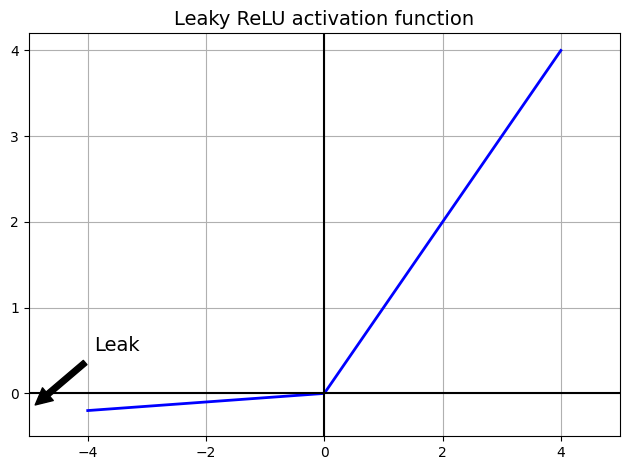

In [ ]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

In [ ]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['activation_layers',
 'backend',
 'deserialize',
 'elu',
 'exponential',
 'gelu',
 'generic_utils',
 'get',
 'hard_sigmoid',
 'keras_export',
 'leaky_relu',
 'legacy_serialization',
 'linear',
 'log_softmax',
 'relu',
 'relu6',
 'selu',
 'serialize',
 'sigmoid',
 'silu',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'sys',
 'tanh',
 'tf']

In [ ]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 1.3121 - accuracy: 0.5977 - val_loss: 0.8987 - val_accuracy: 0.7164
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.8129 - accuracy: 0.7354 - val_loss: 0.7228 - val_accuracy: 0.7694
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.6933 - accuracy: 0.7739 - val_loss: 0.6496 - val_accuracy: 0.7920
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.6282 - accuracy: 0.7950 - val_loss: 0.5926 - val_accuracy: 0.8110
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5864 - accuracy: 0.8074 - val_loss: 0.5590 - val_accuracy: 0.8216
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5570 - accuracy: 0.8154 - val_loss: 0.5344 - val_accuracy: 0.8236
Epoch 7/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5350 - accuracy: 0.8212 - val_loss: 0.5145 - val_acc

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
def my_softplus(z): # return value is just tf.nn.softplus(z)
    return tf.math.log(tf.exp(z) + 1.0)

def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights): # return value is just tf.nn.relu(weights)
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [ ]:
layer = keras.layers.Dense(1, activation=my_softplus,
                           kernel_initializer=my_glorot_initializer,
                           kernel_regularizer=my_l1_regularizer,
                           kernel_constraint=my_positive_weights)
     

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [ ]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 3s 4ms/step - loss: 1.6556 - mae: 0.9337 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.6418 - mae: 0.5244 - val_loss: inf - val_mae: inf


In [ ]:
model.save("my_model_with_many_custom_parts.h5")

In [ ]:
model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
       "my_l1_regularizer": my_l1_regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

In [ ]:
class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor
    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))
    def get_config(self):
        return {"factor": self.factor}

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=MyL1Regularizer(0.01),
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [ ]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 4ms/step - loss: 1.6665 - mae: 0.8730 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.6784 - mae: 0.5232 - val_loss: inf - val_mae: inf


In [ ]:
model.save("my_model_with_many_custom_parts.h5")

In [ ]:
model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
       "MyL1Regularizer": MyL1Regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

###Using Fashion MNIST dataset to test a model using custom training loop

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255.
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test.astype(np.float32) / 255.

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax"),
])

In [ ]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
mean_loss = tf.keras.metrics.Mean()
metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]

In [ ]:
with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc=f"Epoch {epoch}/{n_epochs}") as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train, y_train)
                with tf.GradientTape() as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)
                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))                    
                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()
                steps.set_postfix(status)
            y_pred = model(X_valid)
            status["val_loss"] = np.mean(loss_fn(y_valid, y_pred))
            status["val_accuracy"] = np.mean(tf.keras.metrics.sparse_categorical_accuracy(
                tf.constant(y_valid, dtype=np.float32), y_pred))
            steps.set_postfix(status)
        for metric in [mean_loss] + metrics:
            metric.reset_states()

All epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Trying with another learning rate and another optimizer

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
lower_layers = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu"),
])
upper_layers = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation="softmax"),
])
model = tf.keras.Sequential([
    lower_layers, upper_layers
])

In [ ]:
lower_optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
upper_optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-3)

In [ ]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
mean_loss = tf.keras.metrics.Mean()
metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]

In [ ]:
with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc=f"Epoch {epoch}/{n_epochs}") as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train, y_train)
                with tf.GradientTape(persistent=True) as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)
                for layers, optimizer in ((lower_layers, lower_optimizer),
                                          (upper_layers, upper_optimizer)):
                    gradients = tape.gradient(loss, layers.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, layers.trainable_variables))
                del tape
                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))                    
                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()
                steps.set_postfix(status)
            y_pred = model(X_valid)
            status["val_loss"] = np.mean(loss_fn(y_valid, y_pred))
            status["val_accuracy"] = np.mean(tf.keras.metrics.sparse_categorical_accuracy(
                tf.constant(y_valid, dtype=np.float32), y_pred))
            steps.set_postfix(status)
        for metric in [mean_loss] + metrics:
            metric.reset_states()

All epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/1718 [00:00<?, ?it/s]

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
lower_layers = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu"),
])
upper_layers = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation="softmax"),
])
model = tf.keras.Sequential([
    lower_layers, upper_layers
])

In [ ]:
lower_optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
upper_optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-3)

In [ ]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
mean_loss = tf.keras.metrics.Mean()
metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]

In [ ]:
with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc=f"Epoch {epoch}/{n_epochs}") as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train, y_train)
                with tf.GradientTape(persistent=True) as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)
                for layers, optimizer in ((lower_layers, lower_optimizer),
                                          (upper_layers, upper_optimizer)):
                    gradients = tape.gradient(loss, layers.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, layers.trainable_variables))
                del tape
                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))                    
                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()
                steps.set_postfix(status)
            y_pred = model(X_valid)
            status["val_loss"] = np.mean(loss_fn(y_valid, y_pred))
            status["val_accuracy"] = np.mean(tf.keras.metrics.sparse_categorical_accuracy(
                tf.constant(y_valid, dtype=np.float32), y_pred))
            steps.set_postfix(status)
        for metric in [mean_loss] + metrics:
            metric.reset_states()

All epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/1718 [00:00<?, ?it/s]

###Custom Kernel Constraint

In [ ]:
from tensorflow.keras.constraints import Constraint
import tensorflow.keras.backend as K

class CustomConstraint(Constraint):
    def __init__(self, max_value=2):
        self.max_value = max_value

    def __call__(self, w):
        return K.clip(w, -self.max_value, self.max_value)

    def get_config(self):
        return {'max_value': self.max_value}

In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

model = Sequential([
    Dense(64, activation='relu', kernel_constraint=CustomConstraint(max_value=2)),
    Dense(10, activation='softmax')
])
